# Компьютерное зрение

##  Решить задачу детекции на основе SSD для датасета [BCCD](https://github.com/Shenggan/BCCD_Dataset)

1. **Сопоставим картинки с координатами**

In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import collections

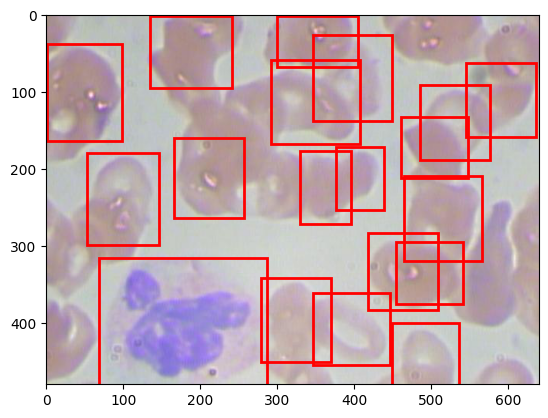

In [2]:
# Определение датасета BCCD
class BCCDDataset(Dataset):
    def __init__(self, root, image_set='train', transform=None):
        self.root = root
        self.transform = transform
        self.image_set = image_set
        
        # Путь к аннотациям и изображениям
        self._annopath = os.path.join(root, 'Annotations', '%s.xml')
        self._imgpath = os.path.join(root, 'JPEGImages', '%s.jpg')
        self._imgsetpath = os.path.join(root, 'ImageSets/Main', '%s.txt')
        
        # Чтение списка изображений
        with open(self._imgsetpath % image_set) as f:
            self.ids = [line.strip() for line in f]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img_id = self.ids[index]
        # Парсинг аннотации
        target = self.parse_voc_xml(ET.parse(self._annopath % img_id).getroot())
        img = Image.open(self._imgpath % img_id).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
    
        boxes = []
        labels = []
        
        # Обработка аннотаций, проверка на наличие объектов
        if 'object' in target['annotation']:
            objects = target['annotation']['object']
            
            # Если объектов несколько, проходим по каждому
            if isinstance(objects, list):
                for obj in objects:
                    if 'bndbox' in obj:
                        bbox = obj['bndbox']
                        boxes.append([float(bbox['xmin']), float(bbox['ymin']),
                                      float(bbox['xmax']), float(bbox['ymax'])])
                        label = obj['name']
                        if label == 'RBC':
                            labels.append(1)
                        elif label == 'WBC':
                            labels.append(2)
                        elif label == 'Platelets':
                            labels.append(3)
            else:
                # Если объект один, обрабатываем его отдельно
                obj = objects
                if 'bndbox' in obj:
                    bbox = obj['bndbox']
                    boxes.append([float(bbox['xmin']), float(bbox['ymin']),
                                  float(bbox['xmax']), float(bbox['ymax'])])
                    label = obj['name']
                    if label == 'RBC':
                        labels.append(1)
                    elif label == 'WBC':
                        labels.append(2)
                    elif label == 'Platelets':
                        labels.append(3)
        
        # Если нет объектов, добавляем пустую метку и бокс
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        return img, boxes, labels

    def parse_voc_xml(self, node):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            voc_dict = {
                node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict


# Добавление визуализации для отладки
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_image_with_boxes(img, boxes, labels):
    """
    Функция для визуализации изображений и боксов.
    """
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

# Пример использования:
dataset = BCCDDataset(root='C:/Users/Yaros/Downloads/BCCD_Dataset-1.0/BCCD_Dataset-1.0/BCCD', image_set='train')
img, boxes, labels = dataset[0]
visualize_image_with_boxes(img, boxes, labels)

2. **Подготовим данные**

In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam

# Определяем трансформации для подготовки данных
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Изменение размера под вход SSD
    transforms.ToTensor(),          # Преобразование в тензор
])

# Создание экземпляров тренировочного и валидационного датасетов
train_dataset = BCCDDataset(root='C:/Users/Yaros/Downloads/BCCD_Dataset-1.0/BCCD_Dataset-1.0/BCCD', 
                            image_set='train', 
                            transform=transform)

val_dataset = BCCDDataset(root='C:/Users/Yaros/Downloads/BCCD_Dataset-1.0/BCCD_Dataset-1.0/BCCD', 
                          image_set='val', 
                          transform=transform)

# Загрузчики данных
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Проверка загрузки данных
img, boxes, labels = next(iter(train_loader))
print(f"Image batch shape: {img[0].shape}")
print(f"Boxes: {boxes[0]}")
print(f"Labels: {labels[0]}")

Image batch shape: torch.Size([3, 300, 300])
Boxes: tensor([[169., 326., 296., 405.],
        [216., 187., 341., 296.],
        [ 93., 128., 179., 208.],
        [105., 245., 195., 362.],
        [  5., 162., 108., 259.],
        [  3., 252., 118., 343.],
        [299., 225., 414., 316.],
        [374., 229., 498., 328.],
        [160., 415., 280., 480.],
        [451., 400., 486., 434.],
        [381., 440., 432., 474.],
        [534., 370., 586., 426.],
        [463., 428., 515., 474.],
        [409.,  59., 460.,  96.],
        [ 71.,  76., 102., 104.],
        [  6., 331., 137., 480.]])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 2])


In [4]:
# Новая функция для collate_fn, чтобы формировать правильные батчи изображений
def collate_fn(batch):
    images, boxes, labels = zip(*batch)
    
    # Сформировать единый тензор для изображений
    images = torch.stack(images, dim=0)
    
    # Поскольку bounding boxes и метки классов для каждого изображения могут иметь разную длину,
    # мы будем возвращать списки тензоров (используем их позже в функции потерь)
    return images, list(boxes), list(labels)

# Обновленный DataLoader с новой функцией collate_fn
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

# Пример использования
img, boxes, labels = next(iter(train_loader))
print(f"Image batch shape: {img.shape}")

Image batch shape: torch.Size([8, 3, 300, 300])


In [5]:
import torch

def match_priors(priors, boxes, iou_threshold=0.5):
    """
    Сопоставляет priors с реальными bounding boxes на основе IoU.
    priors: тензор размерности (N, 4) — список анкерных боксов.
    boxes: список тензоров размерности (M_i, 4) для каждого изображения — реальные bounding boxes.
    Возвращает: loc_targets и conf_targets для каждого изображения.
    """
    loc_targets = []
    conf_targets = []

    # Преобразуем анкерные боксы в нужный формат (x_center, y_center, width, height)
    priors = priors.view(-1, 4)

    for target in boxes:
        if target.numel() == 0:
            # Если нет объектов, добавляем нулевые боксы и метки фона
            loc_targets.append(torch.zeros_like(priors))
            conf_targets.append(torch.zeros(priors.size(0), dtype=torch.long))
            continue

        # Вычисляем IoU между priors и target boxes
        ious = calculate_iou(priors, target)
        best_iou_idx = ious.argmax(dim=1)
        best_ious = ious.max(dim=1)[0]

        # Убедитесь, что размеры совпадают
        if best_iou_idx.size(0) != priors.size(0):
            best_iou_idx = best_iou_idx[:priors.size(0)]

        # Формируем loc_targets для регрессии боксов
        best_boxes = target[best_iou_idx]
        
        # Убедимся, что размеры совпадают перед добавлением
        if best_boxes.size(0) != priors.size(0):
            best_boxes = best_boxes[:priors.size(0), :]
        
        loc_targets.append(best_boxes)

        # Формируем conf_targets для классификации (1 - объект, 0 - фон)
        conf = torch.zeros(len(priors), dtype=torch.long)
        conf[best_ious > iou_threshold] = 1  # Если IoU > порога, присваиваем класс объекта
        conf_targets.append(conf)

    # Преобразуем списки в тензоры и убедимся, что размеры батчей совпадают
    loc_targets = torch.stack(loc_targets, dim=0)
    conf_targets = torch.stack(conf_targets, dim=0)

    return loc_targets, conf_targets

In [6]:
def calculate_iou(priors, boxes):
    """
    Вычисляет IoU (Intersection over Union) между priors и bboxes.
    priors: тензор размерности (N, 4) — список анкерных боксов.
    boxes: тензор размерности (M, 4) — реальные bounding boxes.
    Возвращает: тензор IoU размерности (N, M), где каждый элемент — IoU между prior и box.
    """
    # Получаем координаты пересечения
    inter_xmin = torch.max(priors[:, 0].unsqueeze(1), boxes[:, 0].unsqueeze(0))
    inter_ymin = torch.max(priors[:, 1].unsqueeze(1), boxes[:, 1].unsqueeze(0))
    inter_xmax = torch.min(priors[:, 2].unsqueeze(1), boxes[:, 2].unsqueeze(0))
    inter_ymax = torch.min(priors[:, 3].unsqueeze(1), boxes[:, 3].unsqueeze(0))

    # Вычисляем площадь пересечения
    inter_area = (inter_xmax - inter_xmin).clamp(min=0) * (inter_ymax - inter_ymin).clamp(min=0)

    # Вычисляем площадь прайоров и реальных боксов
    priors_area = (priors[:, 2] - priors[:, 0]) * (priors[:, 3] - priors[:, 1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    # Вычисляем объединенную площадь
    union_area = priors_area.unsqueeze(1) + boxes_area.unsqueeze(0) - inter_area

    # Возвращаем IoU
    iou = inter_area / union_area
    return iou

In [48]:
import numpy as np
import torch

# Функция для генерации прайоров (анкерных боксов)
def generate_priors(feature_map_sizes, aspect_ratios, scales, image_size=300):
    priors = []
    for k, f_map in enumerate(feature_map_sizes):
        for i in range(f_map):
            for j in range(f_map):
                cx = (j + 0.5) / f_map
                cy = (i + 0.5) / f_map

                # Прайоры для каждого соотношения сторон
                for ratio in aspect_ratios[k]:
                    ratio_sqrt = np.sqrt(ratio)
                    priors.append([cx, cy, scales[k] * ratio_sqrt / image_size, scales[k] / ratio_sqrt / image_size])

                # Дополнительный прайор со средним масштабом
                if k + 1 < len(scales):
                    avg_scale = np.sqrt(scales[k] * scales[k + 1])
                    priors.append([cx, cy, avg_scale / image_size, avg_scale / image_size])
                    
    # Перепроверка количества прайоров
    print(f"Generated total priors: {len(priors)}")
    return torch.tensor(priors, dtype=torch.float32)

# Пересчет и создание priors
feature_map_sizes = [9, 9, 5, 3, 2, 1]
aspect_ratios = [
    [1.0, 2.0, 0.5],
    [1.0, 2.0, 3.0, 0.5, 1/3],
    [1.0, 2.0, 3.0, 0.5, 1/3],
    [1.0, 2.0, 3.0, 0.5, 1/3],
    [1.0, 2.0, 0.5],
    [1.0, 2.0, 0.5]
]
scales = [0.1, 0.2, 0.375, 0.55, 0.725, 0.9]

priors = generate_priors(feature_map_sizes, aspect_ratios, scales)
print(f"Total generated priors: {priors.size(0)}")

Generated total priors: 1033
Total generated priors: 1033


3. **Определим модель SSD**

In [45]:
from torchvision.models import vgg16, VGG16_Weights

class SSD300(torch.nn.Module):
    def __init__(self, num_classes=4):
        super(SSD300, self).__init__()
        self.num_classes = num_classes
        
        # Загружаем предварительно обученную модель VGG16
        self.base = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features

        # Дополнительные слои для SSD
        self.extra_layers = self._add_extra_layers()
        
        # Слои для предсказания координат и классов
        self.loc_layers = self._add_loc_layers()
        self.conf_layers = self._add_conf_layers()

    def _add_extra_layers(self):
        layers = []
        layers += [torch.nn.Conv2d(512, 1024, kernel_size=3, padding=1, stride=1)]
        layers += [torch.nn.Conv2d(1024, 512, kernel_size=3, padding=1, stride=2)]
        layers += [torch.nn.Conv2d(512, 256, kernel_size=3, padding=1, stride=2)]
        layers += [torch.nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=2)]
        layers += [torch.nn.Conv2d(256, 128, kernel_size=3, padding=1, stride=2)]
        return torch.nn.ModuleList(layers)


    def _add_loc_layers(self):
        return torch.nn.ModuleList([
            torch.nn.Conv2d(512, 16, kernel_size=3, padding=1),  # 4 priors на уровне 0 → 16 каналов
            torch.nn.Conv2d(1024, 16, kernel_size=3, padding=1), # 4 priors на уровне 1 → 16 каналов
            torch.nn.Conv2d(512, 24, kernel_size=3, padding=1),  # 6 priors на уровне 2 → 24 канала
            torch.nn.Conv2d(256, 24, kernel_size=3, padding=1),  # 6 priors на уровне 3 → 24 канала
            torch.nn.Conv2d(256, 16, kernel_size=3, padding=1),  # 4 priors на уровне 4 → 16 каналов
            torch.nn.Conv2d(128, 4, kernel_size=3, padding=1)    # 4 priors на уровне 5 → 4 канала
        ])
    
    def _add_conf_layers(self):
        num_classes = 4
        return torch.nn.ModuleList([
            torch.nn.Conv2d(512, 16 * num_classes, kernel_size=3, padding=1),
            torch.nn.Conv2d(1024, 16 * num_classes, kernel_size=3, padding=1),
            torch.nn.Conv2d(512, 24 * num_classes, kernel_size=3, padding=1),
            torch.nn.Conv2d(256, 24 * num_classes, kernel_size=3, padding=1),
            torch.nn.Conv2d(256, 16 * num_classes, kernel_size=3, padding=1),
            torch.nn.Conv2d(128, 4 * num_classes, kernel_size=3, padding=1)
        ])


    # В методе forward() модели SSD300 добавьте следующий отладочный вывод
    def forward(self, x):
        features = []
        x = self.base(x)
        features.append(x)
    
        for extra_layer in self.extra_layers:
            x = extra_layer(x)
            features.append(x)
    
        loc_preds = []
        conf_preds = []
    
        # Пройти по всем feature maps и сделать предсказания
        for idx, (loc_layer, conf_layer) in enumerate(zip(self.loc_layers, self.conf_layers)):
            loc_pred = loc_layer(features[idx])
            loc_pred = loc_pred.permute(0, 2, 3, 1).contiguous()
            
            # Добавьте отладочный вывод
            print(f"Feature map {idx}: {features[idx].shape}, loc_pred size: {loc_pred.shape}")
    
            loc_pred = loc_pred.view(loc_pred.size(0), -1, 4)
            loc_preds.append(loc_pred)
    
            conf_pred = conf_layer(features[idx])
            conf_pred = conf_pred.permute(0, 2, 3, 1).contiguous()
            conf_pred = conf_pred.view(conf_pred.size(0), -1, self.num_classes)
            conf_preds.append(conf_pred)
    
        # Вернуть только предсказания
        return torch.cat(loc_preds, 1), torch.cat(conf_preds, 1)




# Создание экземпляра модели
model = SSD300(num_classes=4)

4. **Обучим модель**

In [26]:
# Определение функции потерь и оптимизатора
def multibox_loss(loc_preds, loc_targets, conf_preds, conf_targets, num_classes):
    loc_loss_fn = torch.nn.SmoothL1Loss(reduction='sum')
    conf_loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

    # Убедитесь, что размеры совпадают перед вычислением потерь
    assert loc_preds.size(1) == loc_targets.size(1), "Количество предсказаний и прайоров должно совпадать!"
    
    loc_loss = loc_loss_fn(loc_preds, loc_targets)
    conf_loss = conf_loss_fn(conf_preds.view(-1, num_classes), conf_targets.view(-1))

    return loc_loss, conf_loss

In [27]:
# Функция для расчета точности
def calculate_accuracy(conf_preds, conf_targets):
    _, predicted_classes = torch.max(conf_preds, 2)  # Предсказанные классы (по вероятностям)
    correct = (predicted_classes == conf_targets).sum().item()  # Количество правильных предсказаний
    accuracy = correct / conf_targets.numel()  # Общая точность
    return accuracy

In [28]:
# Генерация прайоров перед началом цикла обучения
# Обновленные параметры
feature_map_sizes = [9, 9, 5, 3, 2, 1]  # Новые размеры карт признаков
aspect_ratios = [
    [1.0, 2.0, 0.5],    # для первого уровня
    [1.0, 2.0, 3.0, 0.5, 1/3],  # для второго уровня
    [1.0, 2.0, 3.0, 0.5, 1/3],  # для третьего уровня
    [1.0, 2.0, 3.0, 0.5, 1/3],  # для четвертого уровня
    [1.0, 2.0, 0.5],    # для пятого уровня
    [1.0, 2.0, 0.5]     # для шестого уровня
]
scales = [0.1, 0.2, 0.375, 0.55, 0.725, 0.9]

# Создание priors
priors = generate_priors(feature_map_sizes, aspect_ratios, scales)
print(f"Total generated priors: {priors.size(0)}")

Level 0: Feature map 9x9, Priors added: 324, Total so far: 324
Level 1: Feature map 9x9, Priors added: 486, Total so far: 810
Level 2: Feature map 5x5, Priors added: 150, Total so far: 960
Level 3: Feature map 3x3, Priors added: 54, Total so far: 1014
Level 4: Feature map 2x2, Priors added: 16, Total so far: 1030
Level 5: Feature map 1x1, Priors added: 4, Total so far: 1034
Expected total priors recalculated: 1034
Generated total priors: 1034
Total generated priors: 1034


In [46]:
# Настройки обучения
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Запуск цикла обучения с отслеживанием метрик
for epoch in range(num_epochs):
    model.train()
    running_loc_loss = 0.0
    running_conf_loss = 0.0
    running_accuracy = 0.0

    for images, boxes, labels in train_loader:
        optimizer.zero_grad()

        # Генерация предсказаний модели
        loc_preds, conf_preds = model(images)

        # Проверка размера предсказаний
        print(f"loc_preds shape: {loc_preds.shape}")

        # Добавить отладочные сообщения перед вызовом match_priors
        print(f"Batch size from DataLoader: {len(boxes)}")
        print(f"Expected number of priors: {priors.size(0)}")
        print(f"Boxes size: {[box.shape for box in boxes]}")

        # Готовим данные для потерь и расчетов
        loc_targets, conf_targets = match_priors(priors, boxes)

        # Проверка размера таргетов
        print(f"loc_targets shape: {loc_targets.shape}")

        # Расчет потерь
        loc_loss, conf_loss = multibox_loss(loc_preds, loc_targets, conf_preds, conf_targets, num_classes=4)
        total_loss = loc_loss + conf_loss

        # Обратное распространение и шаг оптимизации
        total_loss.backward()
        optimizer.step()

        # Обновление метрик
        running_loc_loss += loc_loss.item()
        running_conf_loss += conf_loss.item()

        # Расчет точности
        accuracy = calculate_accuracy(conf_preds, conf_targets)
        running_accuracy += accuracy

    avg_loc_loss = running_loc_loss / len(train_loader)
    avg_conf_loss = running_conf_loss / len(train_loader)
    avg_accuracy = running_accuracy / len(train_loader)

    # Вывод результатов за эпоху
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loc Loss: {avg_loc_loss:.4f}, '
          f'Conf Loss: {avg_conf_loss:.4f}, '
          f'Total Loss: {avg_loc_loss + avg_conf_loss:.4f}, '
          f'Accuracy: {avg_accuracy:.4f}')

Feature map 0: torch.Size([8, 512, 9, 9]), loc_pred size: torch.Size([8, 9, 9, 16])
Feature map 1: torch.Size([8, 1024, 9, 9]), loc_pred size: torch.Size([8, 9, 9, 16])
Feature map 2: torch.Size([8, 512, 5, 5]), loc_pred size: torch.Size([8, 5, 5, 24])
Feature map 3: torch.Size([8, 256, 3, 3]), loc_pred size: torch.Size([8, 3, 3, 24])
Feature map 4: torch.Size([8, 256, 2, 2]), loc_pred size: torch.Size([8, 2, 2, 16])
Feature map 5: torch.Size([8, 128, 1, 1]), loc_pred size: torch.Size([8, 1, 1, 4])
loc_preds shape: torch.Size([8, 869, 4])
Batch size from DataLoader: 8
Expected number of priors: 1033
Boxes size: [torch.Size([11, 4]), torch.Size([4, 4]), torch.Size([14, 4]), torch.Size([16, 4]), torch.Size([11, 4]), torch.Size([13, 4]), torch.Size([16, 4]), torch.Size([12, 4])]
loc_targets shape: torch.Size([8, 1033, 4])


AssertionError: Количество предсказаний и прайоров должно совпадать!

In [51]:
# Определение датасета BCCD
class BCCDDataset(Dataset):
    def __init__(self, root, image_set='train', transform=None):
        self.root = root
        self.transform = transform
        self.image_set = image_set
        # Путь к аннотациям и изображениям
        self._annopath = os.path.join(root, 'C:/Users/Yaros/Downloads/BCCD_Dataset-1.0/BCCD_Dataset-1.0/BCCD/Annotations', '%s.xml')
        self._imgpath = os.path.join(root, 'C:/Users/Yaros/Downloads/BCCD_Dataset-1.0/BCCD_Dataset-1.0/BCCD/JPEGImages', '%s.jpg')
        self._imgsetpath = os.path.join(root, 'C:/Users/Yaros/Downloads/BCCD_Dataset-1.0/BCCD_Dataset-1.0/BCCD/ImageSets', 'Main', '%s.txt')
        
        # Чтение списка изображений
        with open(self._imgsetpath % image_set) as f:
            self.ids = [line.strip() for line in f]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img_id = self.ids[index]
        # Парсинг аннотации
        target = self.parse_voc_xml(ET.parse(self._annopath % img_id).getroot())
        img = Image.open(self._imgpath % img_id).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
    
        boxes = []
        labels = []
        
        # Исправляем ошибку с неправильной структурой доступа к полям
        if 'object' in target['annotation']:
            objects = target['annotation']['object']
            
            # Если объектов несколько, проходим по каждому
            if isinstance(objects, list):
                for obj in objects:
                    if 'bndbox' in obj:
                        bbox = obj['bndbox']
                        boxes.append([float(bbox['xmin']), float(bbox['ymin']),
                                      float(bbox['xmax']), float(bbox['ymax'])])
                        label = obj['name']
                        if label == 'RBC':
                            labels.append(1)
                        elif label == 'WBC':
                            labels.append(2)
                        elif label == 'Platelets':
                            labels.append(3)
            else:
                # Если объект один, обрабатываем его отдельно
                obj = objects
                if 'bndbox' in obj:
                    bbox = obj['bndbox']
                    boxes.append([float(bbox['xmin']), float(bbox['ymin']),
                                  float(bbox['xmax']), float(bbox['ymax'])])
                    label = obj['name']
                    if label == 'RBC':
                        labels.append(1)
                    elif label == 'WBC':
                        labels.append(2)
                    elif label == 'Platelets':
                        labels.append(3)
        else:
            # Если нет объектов, добавляем пустую метку и бокс
            boxes.append([0, 0, 0, 0])
            labels.append(0)
    
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        return img, boxes, labels


    def parse_voc_xml(self, node):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            voc_dict = {
                node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

2. **Создадим модель SSD**

In [52]:
# Определение модели SSD с использованием VGG16
from torchvision.models import vgg16, VGG16_Weights

class SSD300(torch.nn.Module):
    def __init__(self, num_classes=4):
        super(SSD300, self).__init__()
        self.num_classes = num_classes
        
        # Загружаем предварительно обученную модель VGG16
        self.base = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features

        # Дополнительные слои для SSD
        self.extra_layers = self._add_extra_layers()
        
        # Слои для предсказания координат и классов
        self.loc_layers = self._add_loc_layers()
        self.conf_layers = self._add_conf_layers()

    def _add_extra_layers(self):
        layers = []
        layers += [torch.nn.Conv2d(512, 1024, kernel_size=3, padding=1)]
        return torch.nn.Sequential(*layers)

    def _add_loc_layers(self):
        return torch.nn.ModuleList([torch.nn.Conv2d(1024, 16, kernel_size=3, padding=1)])

    def _add_conf_layers(self):
        return torch.nn.ModuleList([torch.nn.Conv2d(1024, self.num_classes * 4, kernel_size=3, padding=1)])

    def forward(self, x):
        x = self.base(x)
        x = self.extra_layers(x)
    
        loc_preds = []
        conf_preds = []
    
        for loc_layer, conf_layer in zip(self.loc_layers, self.conf_layers):
            # Преобразуем предсказания локализации (координаты боксов)
            loc_pred = loc_layer(x)
            loc_pred = loc_pred.permute(0, 2, 3, 1).contiguous()
            loc_pred = loc_pred.view(loc_pred.size(0), -1, 4)  # Преобразуем в нужный формат
            loc_preds.append(loc_pred)
            
            # Преобразуем предсказания классов
            conf_pred = conf_layer(x)
            conf_pred = conf_pred.permute(0, 2, 3, 1).contiguous()
            conf_pred = conf_pred.view(conf_pred.size(0), -1, self.num_classes)
            conf_preds.append(conf_pred)
        
        # Соединяем все предсказания для каждого слоя
        return torch.cat(loc_preds, 1), torch.cat(conf_preds, 1)

In [53]:
# Функция для генерации прайоров
def generate_priors(feature_map_sizes, aspect_ratios, scales, image_size=300):
    priors = []
    
    # Перебор карт признаков
    for k, f_map in enumerate(feature_map_sizes):
        for i in range(f_map):
            for j in range(f_map):
                cx = (j + 0.5) / f_map
                cy = (i + 0.5) / f_map
                
                # Добавляем прайоры для каждого соотношения сторон
                for ratio in aspect_ratios[k]:
                    ratio_sqrt = np.sqrt(ratio)
                    priors.append([cx, cy, scales[k] * ratio_sqrt / image_size, scales[k] / ratio_sqrt / image_size])
                
                # Добавляем "средний" прайор только если не на последней итерации
                if k + 1 < len(scales):
                    priors.append([cx, cy, scales[k + 1] / image_size, scales[k + 1] / image_size])
    
    # Ограничиваем количество прайоров до числа предсказаний модели (324)
    priors = priors[:324]  # Убедитесь, что количество прайоров совпадает с количеством предсказаний
    
    return torch.tensor(priors, dtype=torch.float32)

In [54]:
def multibox_loss(loc_preds, loc_targets, conf_preds, conf_targets, num_classes):
    """
    Лосс-функция для вычисления потерь в модели SSD.
    Содержит SmoothL1 для координат и CrossEntropy для классов.
    """
    bbox_loss_fn = torch.nn.SmoothL1Loss(reduction='sum')
    loc_loss = bbox_loss_fn(loc_preds, loc_targets)  # Лосс для координат

    conf_loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
    conf_loss = conf_loss_fn(conf_preds.view(-1, num_classes), conf_targets.view(-1))  # Лосс для классов

    # Общая ошибка
    return loc_loss + conf_loss

In [55]:
# Оценка точности
def calculate_accuracy(conf_preds, conf_targets):
    _, predicted_classes = torch.max(conf_preds, 1)
    correct = (predicted_classes == conf_targets).sum().item()
    accuracy = correct / conf_targets.size(0)
    return accuracy

3. **Обучим модель**

In [56]:
# Подготовка данных и обучение
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

In [57]:
def collate_fn(batch):
    images = []
    boxes = []
    labels = []

    for b in batch:
        images.append(b[0])  # Изображение
        boxes.append(b[1])   # Координаты боксов
        labels.append(b[2])  # Метки классов

    # Преобразуем список изображений в один тензор (batch) с помощью stack
    images = torch.stack(images, dim=0)
    
    return images, boxes, labels

In [58]:
# Загрузчики данных
train_dataset = BCCDDataset(root='C:/Users/Yaros/Downloads/BCCD_Dataset-1.0/BCCD_Dataset-1.0/BCCD', image_set='train', transform=transform)
val_dataset = BCCDDataset(root='C:/Users/Yaros/Downloads/BCCD_Dataset-1.0/BCCD_Dataset-1.0/BCCD', image_set='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

# Определяем модель, оптимизатор и функцию потерь
model = SSD300(num_classes=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [59]:
def match_priors(priors, targets, iou_threshold=0.5):
    """
    Сопоставляет priors с реальными bounding boxes на основе IoU.
    priors: тензор размерности (N, 4) — список анкерных боксов.
    targets: список тензоров размерности (M_i, 4) для каждого изображения — реальные bounding boxes.
    Возвращает: loc_targets и conf_targets для каждого изображения.
    """
    loc_targets = []
    conf_targets = []

    for target in targets:
        ious = calculate_iou(priors, target)  # Вычисляем IoU между priors и реальными bboxes
        best_iou_idx = ious.argmax(dim=1)    # Находим индекс лучшего IoU для каждого prior
        best_ious = ious.max(dim=1)[0]       # Находим лучший IoU для каждого prior

        # Формируем loc_targets для регрессии боксов
        best_boxes = target[best_iou_idx]  # Выбираем лучшие боксы для каждого prior
        loc_targets.append(best_boxes)

        # Формируем conf_targets для классификации (1 - объект, 0 - фон)
        conf = torch.zeros(len(priors), dtype=torch.long)  # По умолчанию все priors — фон
        conf[best_ious > iou_threshold] = 1  # Если IoU > порога, присваиваем класс объекта
        conf_targets.append(conf)

    # Преобразуем список в тензор и ограничиваем количество элементов до 324
    loc_targets = torch.stack(loc_targets, dim=0)[:len(priors)]
    conf_targets = torch.stack(conf_targets, dim=0)[:len(priors)]

    return loc_targets, conf_targets

In [60]:
def calculate_iou(priors, boxes):
    """
    Вычисляет IoU (Intersection over Union) между priors и bboxes.
    priors: тензор размерности (N, 4) — список анкерных боксов.
    boxes: тензор размерности (M, 4) — реальные bounding boxes.
    Возвращает: тензор IoU размерности (N, M), где каждый элемент — IoU между prior и box.
    """
    # Получаем координаты пересечения
    inter_xmin = torch.max(priors[:, 0].unsqueeze(1), boxes[:, 0].unsqueeze(0))
    inter_ymin = torch.max(priors[:, 1].unsqueeze(1), boxes[:, 1].unsqueeze(0))
    inter_xmax = torch.min(priors[:, 2].unsqueeze(1), boxes[:, 2].unsqueeze(0))
    inter_ymax = torch.min(priors[:, 3].unsqueeze(1), boxes[:, 3].unsqueeze(0))

    # Вычисляем площадь пересечения
    inter_area = (inter_xmax - inter_xmin).clamp(min=0) * (inter_ymax - inter_ymin).clamp(min=0)

    # Вычисляем площадь прайоров и реальных боксов
    priors_area = (priors[:, 2] - priors[:, 0]) * (priors[:, 3] - priors[:, 1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

    # Вычисляем объединенную площадь
    union_area = priors_area.unsqueeze(1) + boxes_area.unsqueeze(0) - inter_area

    # Возвращаем IoU
    iou = inter_area / union_area
    return iou

In [61]:
# Цикл обучения
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for images, boxes, labels in train_loader:
        optimizer.zero_grad()
        
        # Генерация предсказаний
        loc_preds, conf_preds = model(images)
        
        # Генерация прайоров
        priors = generate_priors(feature_map_sizes, aspect_ratios, scales)
        
        # Сопоставление priors с реальными координатами боксов
        loc_targets, conf_targets = match_priors(priors, boxes)
        
        # Проверка размеров перед функцией потерь
        print(f'loc_preds: {loc_preds.size()}, loc_targets: {loc_targets.size()}')
        
        # Вычисление функции потерь
        loss = multibox_loss(loc_preds, loc_targets, conf_preds, conf_targets, num_classes=4)
        
        loss.backward()
        optimizer.step()
        
        # Рассчет точности
        accuracy = calculate_accuracy(conf_preds.view(-1, 4), conf_targets.view(-1))
        running_loss += loss.item()
        running_accuracy += accuracy
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {running_accuracy/len(train_loader)}')

loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: torch.Size([8, 324, 4])
loc_preds: torch.Size([8, 324, 4]), loc_targets: to

4. Проверяем результат

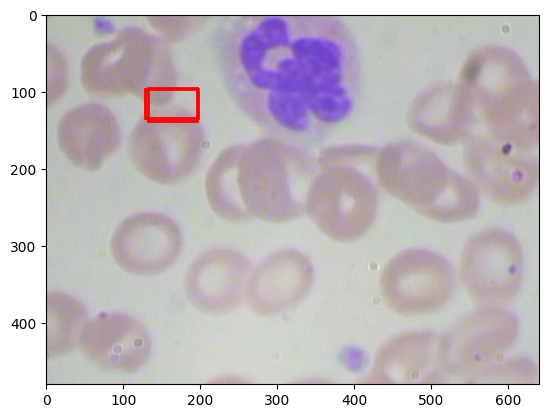

In [76]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

def normalize_boxes(boxes, image_width, image_height):
    """
    Нормализует боксы в границы размеров изображения.
    """
    normalized_boxes = []
    max_value = 1e8  # предполагаем, что координаты должны быть в пределах этого значения
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        # Приводим значения к диапазону от 0 до размера изображения
        xmin = (xmin / max_value) * image_width
        ymin = (ymin / max_value) * image_height
        xmax = (xmax / max_value) * image_width
        ymax = (ymax / max_value) * image_height
        normalized_boxes.append([xmin, ymin, xmax, ymax])
    return normalized_boxes

# Пример: замените эти координаты на ваши реальные значения
boxes = [
    (20515754.0, 19648464.0, 30636504.0, 28554316.0),
    (19938968.0, 19906318.0, 30709878.0, 27817750.0),
    # Добавьте остальные координаты
]

# Замените путь на ваш
image_path = 'C:/Users/Yaros/Downloads/BCCD_Dataset-1.0/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00375.jpg'
image = Image.open(image_path)
image_width, image_height = image.size

# Нормализуем боксы
normalized_boxes = normalize_boxes(boxes, image_width, image_height)

# Визуализация изображения и bounding boxes
fig, ax = plt.subplots(1)
ax.imshow(image)

# Рисуем каждую нормализованную рамку
for box in normalized_boxes:
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()


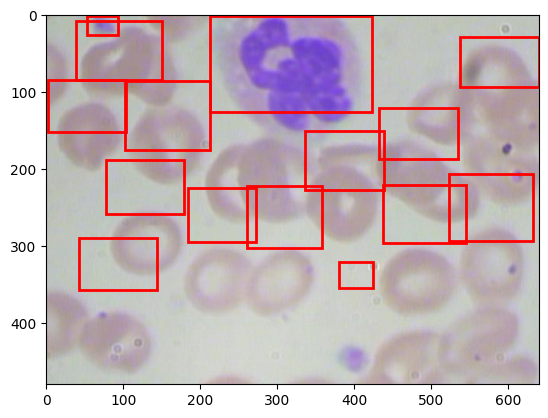

In [79]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

def normalize_boxes(boxes, image_width, image_height):
    """
    Нормализует боксы в границы размеров изображения.
    """
    normalized_boxes = []
    max_value = max(max(box) for box in boxes)  # определяем максимальное значение координат
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        # Приводим значения к диапазону от 0 до размера изображения
        xmin = (xmin / max_value) * image_width
        ymin = (ymin / max_value) * image_height
        xmax = (xmax / max_value) * image_width
        ymax = (ymax / max_value) * image_height
        normalized_boxes.append([xmin, ymin, xmax, ymax])
    return normalized_boxes

# Пример: замените эти координаты на ваши реальные значения
boxes = [
    (77, 250, 177, 343),  # RBC 1
    (183, 297, 270, 391),  # RBC 2
    (259, 294, 356, 400),  # RBC 3
    (434, 292, 541, 392),  # RBC 4
    (520, 273, 628, 389),  # RBC 5
    (42, 383, 143, 473),   # RBC 6
    (101, 113, 211, 233),  # RBC 7
    (2, 112, 103, 202),    # RBC 8
    (333, 199, 436, 301),  # RBC 9
    (429, 160, 531, 247),  # RBC 10
    (534, 37, 636, 124),   # RBC 11
    (38, 11, 149, 112),    # RBC 12
    (377, 425, 421, 470),  # Platelets
    (211, 1, 420, 167),    # WBC
    (52, 1, 92, 34)        # Platelets 2
]

image_path = 'C:/Users/Yaros/Downloads/BCCD_Dataset-1.0/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00375.jpg'  
image = Image.open(image_path)
image_width, image_height = image.size

# Нормализуем боксы
normalized_boxes = normalize_boxes(boxes, image_width, image_height)

# Визуализация изображения и bounding boxes
fig, ax = plt.subplots(1)
ax.imshow(image)

# Рисуем каждую нормализованную рамку
for box in normalized_boxes:
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [80]:
def decode_boxes(loc_preds, priors, variances=[0.1, 0.2]):
    """
    Преобразует предсказанные относительные боксы в абсолютные с помощью prior boxes.
    
    loc_preds: предсказанные координаты локализации
    priors: prior boxes (анкерные боксы)
    variances: коэффициенты масштабирования для координат
    
    Возвращает: предсказанные боксы в формате (xmin, ymin, xmax, ymax)
    """
    boxes = torch.cat((
        priors[:, :2] + loc_preds[:, :2] * variances[0] * priors[:, 2:],  # cx, cy
        priors[:, 2:] * torch.exp(loc_preds[:, 2:] * variances[1])  # width, height
    ), 1)
    
    boxes[:, :2] -= boxes[:, 2:] / 2  # преобразуем из (cx, cy, w, h) в (xmin, ymin)
    boxes[:, 2:] += boxes[:, :2]  # преобразуем в (xmin, ymin, xmax, ymax)
    
    return boxes

# Пример использования
loc_preds, conf_preds = model(images)  # предсказания от модели
decoded_boxes = decode_boxes(loc_preds[0], priors)  # декодирование предсказаний для первого изображения


In [81]:
confidence_threshold = 0.5
conf_scores = conf_preds[0].softmax(dim=-1)  # Преобразуем предсказания в вероятности
conf_mask = conf_scores[:, 1:].max(dim=1)[0] > confidence_threshold  # Фильтруем по порогу
filtered_boxes = decoded_boxes[conf_mask]  # Оставляем только те боксы, которые прошли порог
filtered_scores = conf_scores[conf_mask]  # Оставляем предсказания классов для оставшихся боксов

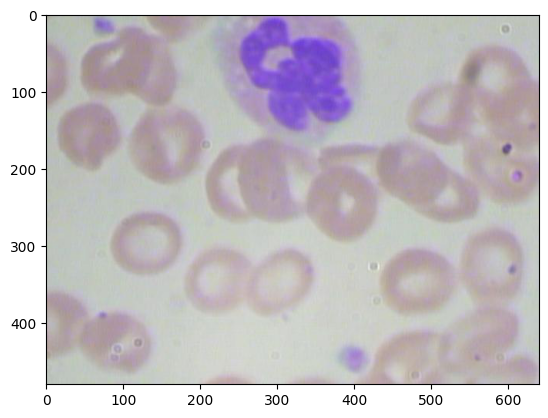

In [83]:
def visualize_predictions(image_path, predicted_boxes):
    """
    Визуализация предсказанных боксов на изображении.
    
    :param image_path: путь к изображению
    :param predicted_boxes: список предсказанных боксов (xmin, ymin, xmax, ymax)
    """
    image = Image.open(image_path)
    image_width, image_height = image.size
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for box in predicted_boxes:
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

# Пример использования
visualize_predictions(image_path, filtered_boxes.detach().cpu().numpy())

In [84]:
print("Predicted boxes:", filtered_boxes.detach().cpu().numpy())

Predicted boxes: []
